In [1]:
!pip install boto3 progressbar2 sfdmap GPUtil

     |████████████████████████████████| 131 kB 21.6 MB/s            
  Using cached progressbar2-3.55.0-py2.py3-none-any.whl (26 kB)
  Using cached sfdmap-0.1.1-py3-none-any.whl
  Using cached GPUtil-1.4.0-py3-none-any.whl
     |████████████████████████████████| 8.5 MB 78.9 MB/s            
  Using cached s3transfer-0.5.0-py3-none-any.whl (79 kB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
  Using cached python_utils-2.7.1-py2.py3-none-any.whl (14 kB)


In [2]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
from matplotlib import pyplot as plt
import matplotlib
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'workdir3')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3.nautilus.optiputer.net'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'workdir3')
s3_saves_dir_path = os.path.join(s3_work_dir_path , 'model_saves')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_data_ver_dir_path = os.path.join(s3_data_dir_path,'HighSNR_12K_V1')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

In [3]:
load_RF_name = 'simple___2021_11_27___22_09_00___standard_RF_max_depth_10'
s3_load_dir_path = os.path.join(s3_saves_dir_path, 'RF', load_RF_name)
print('loading from folder (S3): {0}'.format(s3_load_dir_path))
X = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'X.npy'))
sim_mat = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'sim_mat.npy'))
dis_mat = 1 - sim_mat

loading from folder (S3): almogh/workdir3/model_saves/RF/simple___2021_11_27___22_09_00___standard_RF_max_depth_10
loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2021_11_27___22_09_00___standard_RF_max_depth_10/X.npy
loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2021_11_27___22_09_00___standard_RF_max_depth_10/sim_mat.npy


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, I_train, I_test = train_test_split(X, np.arange(X.shape[0]), train_size=9000, random_state=seed)

batch_size = 128

from NN import DistillationDataGenerator
train_gen = DistillationDataGenerator(X_train, dis_mat[I_train,:][:,I_train], shuffle=False, seed=seed, batch_size=batch_size, full_epoch=True)
val_gen = DistillationDataGenerator(X_val, dis_mat[I_test,:][:,I_test], shuffle=False, seed=seed, batch_size=batch_size, full_epoch=True)

In [4]:
from s3 import to_s3_npy
Z = from_s3_npy(s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/simple___2021_12_06___21_36_21___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/Z.npy')

loading from uri: s3://tau-astro/almogh/workdir3/model_saves/NN/simple___2021_12_06___21_36_21___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/Z.npy


In [22]:
train_gen.couples

array([[   0,    0],
       [   1,    0],
       [   2,    0],
       ...,
       [8997, 8999],
       [8998, 8999],
       [8999, 8999]])

In [9]:
Z = Z.reshape(9000,9000)

In [14]:
dis_mat = dis_mat[I_train,:][:,I_train]

In [15]:
err = abs(Z-dis_mat)

In [18]:
# calculate histogram
N = 1000
edges = np.linspace(0,1,N+1)
centers = (edges[:-1]+edges[1:])/2
counts,_ = np.histogram(err, bins=edges)
counts = np.divide(counts, np.sum(counts))

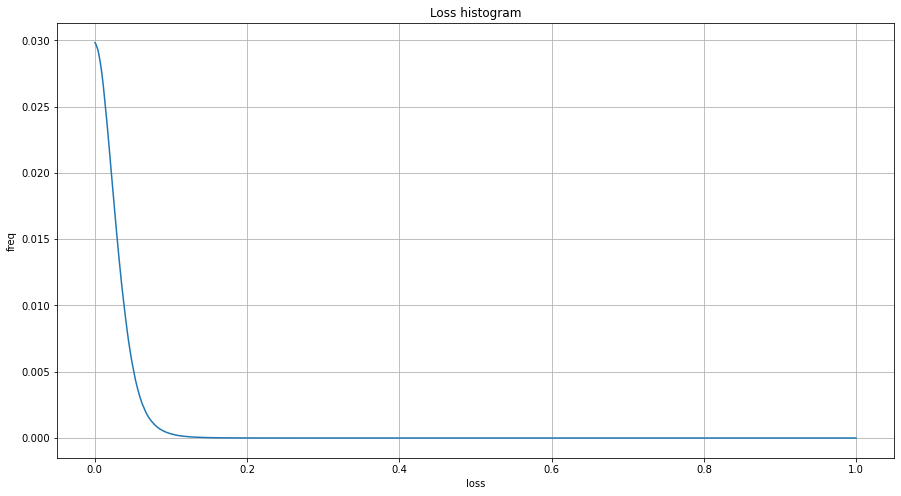

In [19]:
from matplotlib import pyplot as plt
hist_fig, hist_ax = plt.subplots(figsize=(15,8))
hist_ax.set_title('Loss histogram')
hist_ax.set_xlabel('loss')
hist_ax.set_ylabel('freq')
hist_ax.grid()
#hist_ax.plot(centers[:150],counts[:150])
hist_ax.plot(centers,counts)

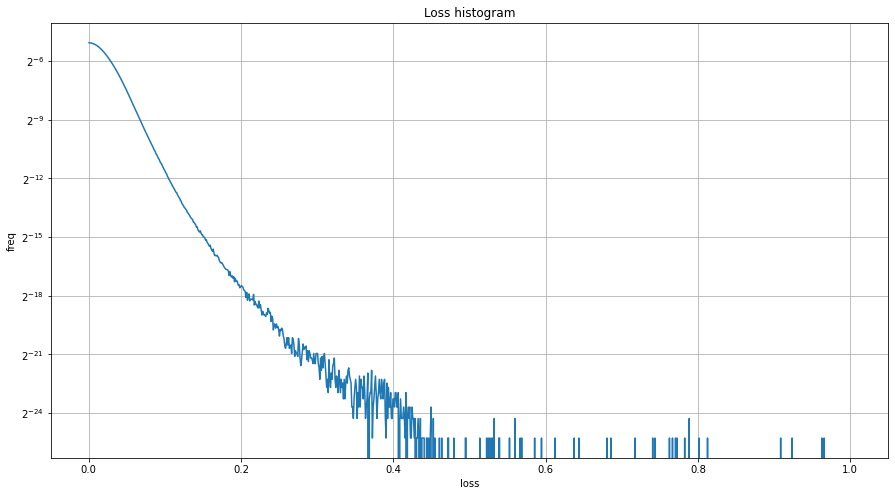

In [20]:
from matplotlib import pyplot as plt
hist_fig, hist_ax = plt.subplots(figsize=(15,8))
hist_ax.set_title('Loss histogram')
hist_ax.set_xlabel('loss')
hist_ax.set_ylabel('freq')
hist_ax.grid()
#hist_ax.plot(centers[:150],counts[:150])
hist_ax.plot(centers,counts)
hist_ax.set_yscale('log', base=2)